In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers


In [2]:
dftrain_raw = pd.read_csv("./data/titanic/train.csv")
dftest_raw = pd.read_csv("./data/titanic/test.csv")
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


特殊字段说明：
* Survived：标签y
* Pclass：票类。转换成onehot编码
* Age：可以添加年龄是否缺失作为辅助特征
* Cabin：所在船舱。是否缺失可以作为辅助特征
* Embarked：登船口。转换成onehot编码

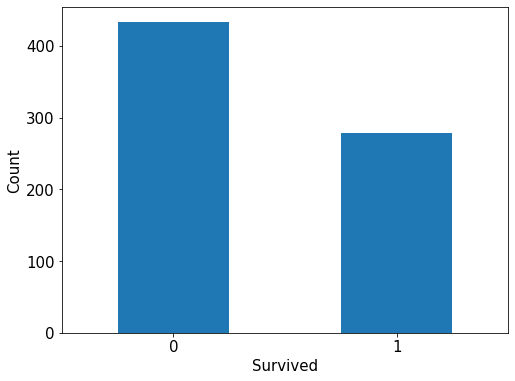

In [3]:
# label的分布情况
ax = dftrain_raw["Survived"].value_counts().plot(kind="bar", figsize=(8,6), fontsize=15, rot=0)
ax.set_ylabel("Count", fontsize=15)
ax.set_xlabel("Survived", fontsize=15)
plt.show()

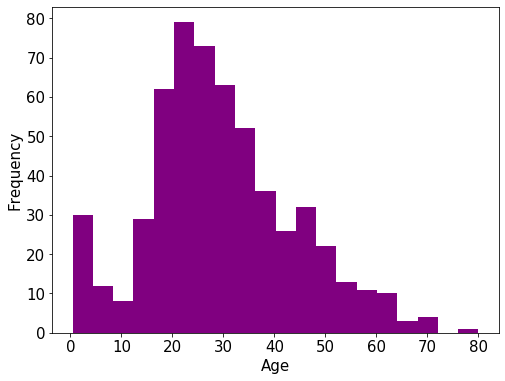

In [4]:
# 年龄的分布情况
ax = dftrain_raw["Age"].plot(kind="hist", bins=20, color="purple", figsize=(8,6), fontsize=15)
ax.set_ylabel("Frequency", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
plt.show()

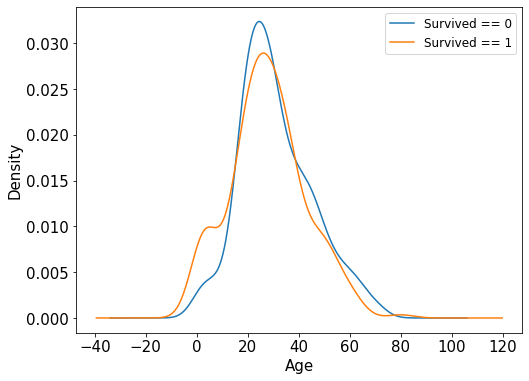

In [5]:
# 年龄与label的相关性
ax = dftrain_raw.query("Survived == 0")["Age"].plot(kind="density", figsize=(8,6), fontsize=15)
dftrain_raw.query("Survived == 1")["Age"].plot(kind="density", figsize=(8,6), fontsize=15)
ax.legend(["Survived == 0", "Survived == 1"], fontsize=12)
ax.set_ylabel("Density", fontsize=15)
ax.set_xlabel("Age", fontsize=15)
plt.show()

In [6]:
# 数据预处理
def preprocessing(dfdata):
    dfresult = pd.DataFrame()

    # Pclass
    dfPclass = pd.get_dummies(dfdata["Pclass"])
    dfPclass.columns = ["Pclass_" + str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult, dfPclass], axis=1)

    # Sex
    dfSex = pd.get_dummies(dfdata["Sex"])
    dfresult = pd.concat([dfresult, dfSex], axis=1)

    # Age
    dfresult["Age"] = dfdata["Age"].fillna(0)
    dfresult["Age_null"] = pd.isna(dfdata["Age"]).astype("int32")

    # SibSp, Parch, Fare
    dfresult["SibSp"] = dfdata["SibSp"]
    dfresult["Parch"] = dfdata["Parch"]
    dfresult["Fare"] = dfdata["Fare"]

    # Cabin
    dfresult["Cabin_null"] = pd.isna(dfdata["Cabin"]).astype("int32")

    # Embarked
    dfEmbarked = pd.get_dummies(dfdata["Embarked"], dummy_na=True)
    dfEmbarked.columns = ["Embarked_" + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)

    return (dfresult)

In [7]:
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw["Survived"].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw["Survived"].values

print("x_train.shape = ", x_train.shape)
print("x_test.shape = ", x_test.shape)

x_train.shape =  (712, 15)
x_test.shape =  (179, 15)


In [8]:
x_train.head(10)

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0
3,0,1,0,0,1,19.0,0,0,0,13.0000,1,0,0,1,0
4,0,0,1,0,1,14.0,0,4,1,39.6875,1,0,0,1,0
5,0,1,0,1,0,55.0,0,0,0,16.0000,1,0,0,1,0
6,0,0,1,0,1,20.5,0,0,0,7.2500,1,0,0,1,0
7,0,1,0,0,1,28.0,0,0,0,10.5000,1,0,0,1,0
8,0,0,1,1,0,45.0,0,1,4,27.9000,1,0,0,1,0
9,0,0,1,0,1,6.0,0,0,1,12.4750,0,0,0,1,0


Keras接口提供3种方式构建模型：
* Sequential按层顺序构建模型
* 函数式API构建任意结构模型
* 继承Model基类构建自定义模型

In [9]:
# Sequential，按层顺序模型
tf.keras.backend.clear_session()

model = models.Sequential()
model.add(layers.Dense(20, activation="relu", input_shape=(15,)))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


训练模型的3中方法：
* 内置fit方法
* 内置的train_on_batch方法
* 自定义训练循环

In [10]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])
history = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2)

Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 3s 4ms/sample - loss: 1.1154 - AUC: 0.3555 - val_loss: 0.8183 - val_AUC: 0.3990
Epoch 2/30
569/569 [==============================] - 0s 260us/sample - loss: 0.7317 - AUC: 0.4865 - val_loss: 0.6980 - val_AUC: 0.6178
Epoch 3/30
569/569 [==============================] - 0s 213us/sample - loss: 0.6591 - AUC: 0.6588 - val_loss: 0.6648 - val_AUC: 0.6613
Epoch 4/30
569/569 [==============================] - 0s 244us/sample - loss: 0.6237 - AUC: 0.6910 - val_loss: 0.6629 - val_AUC: 0.6662
Epoch 5/30
569/569 [==============================] - 0s 253us/sample - loss: 0.6195 - AUC: 0.7030 - val_loss: 0.6599 - val_AUC: 0.6686
Epoch 6/30
569/569 [==============================] - 0s 239us/sample - loss: 0.6106 - AUC: 0.7105 - val_loss: 0.6491 - val_AUC: 0.6767
Epoch 7/30
569/569 [==============================] - 0s 288us/sample - loss: 0.6020 - AUC: 0.7179 - val_loss: 0.6384 - val_AUC: 0.6823
Epoc

In [11]:
# 评估模型
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history["val_" + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, "bo--")
    plt.plot(epochs, val_metrics, "ro-")
    plt.title("Training and validation " + metric)
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, "val_" + metric])
    plt.show()

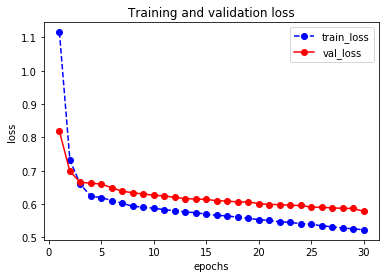

In [12]:
plot_metric(history, "loss")

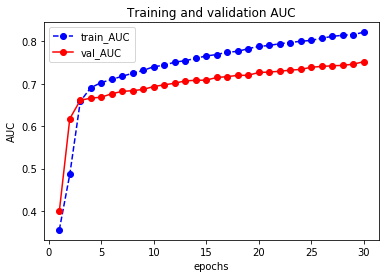

In [20]:
plot_metric(history, "AUC")

In [21]:
model.evaluate(x=x_test, y=y_test)

179/179 [==============================] - 0s 2ms/sample - loss: 0.5168 - AUC: 0.8086


[0.5168302888310822, 0.8085659]

In [22]:
# 使用模型
# 预测概率
model.predict(x_test[0:10])

array([[0.27043635],
       [0.32503504],
       [0.3703274 ],
       [0.7355145 ],
       [0.41995215],
       [0.47630152],
       [0.23600532],
       [0.62275314],
       [0.48618564],
       [0.17302184]], dtype=float32)

In [23]:
# 预测类别
model.predict_classes(x_test[0:10])

array([[0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0]])

In [24]:
from sklearn.metrics import precision_score, accuracy_score

y_score = model.predict_classes(x_test)
print("precision = ", precision_score(y_test, y_score))
print("accuracy = ", accuracy_score(y_test, y_score))

precision =  0.7419354838709677
accuracy =  0.7318435754189944


In [25]:
# 保存模型
# 仅保存权重张量
model.save_weights("./model/day01_model_weight.ckpt", save_format="tf")

# 保存模型结构和参数
model.save("./model/day01_savemodel", save_format="tf")
print("export saved model")

NotFoundError: Failed to create a directory: ./model/day01_savemodel\variables; No such file or directory

In [26]:
model_loaded = tf.keras.models.load_model("./model/day01_savemodel")
model_loaded.evaluate(x=x_test, y=y_test)

OSError: SavedModel file does not exist at: ./model/day01_savemodel/{saved_model.pbtxt|saved_model.pb}